# Análisis de Datos de Alquileres en Madrid

### 1. Carga y Limpieza de Datos


In [59]:
# Librerías de la biblioteca estándar
import os
import warnings

# Librerías externas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# Scikit-Learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [60]:
# Carga del dataset
df = pd.read_csv('idealista.csv')

# Mostrar información general del dataset
print("\nInformación general del dataset:")
print(df.info())
print(df.head())

print("\nEstadísticas descriptivas para variables numéricas:")
print(df.describe())

print("\nListado de Columnas:")
print(df.columns)

print("\nDimensión del dataset:")
df.shape 


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9229 entries, 0 to 9228
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   web_id             9229 non-null   int64  
 1   url                9229 non-null   object 
 2   title              9229 non-null   object 
 3   type               9229 non-null   object 
 4   price              9229 non-null   int64  
 5   deposit            5407 non-null   float64
 6   private_owner      9229 non-null   bool   
 7   professional_name  7622 non-null   object 
 8   floor_built        9229 non-null   int64  
 9   floor_area         3938 non-null   float64
 10  floor              8908 non-null   object 
 11  year_built         2893 non-null   float64
 12  orientation        4411 non-null   object 
 13  bedrooms           9229 non-null   int64  
 14  bathrooms          9229 non-null   int64  
 15  second_hand        9229 non-null   boo

(9229, 32)

In [61]:
# vamos a eliminar last_updated, web_id, tittle porque no aportan nada
df = df.drop(['last_update', 'web_id', 'title', 'url', 'location'], axis=1)

# tambien eliminamos postal_code porque para el análisis será suficiente con district
df = df.drop(['postalcode'], axis=1)

Se elimina 'last_update', 'web_id', 'title', 'url' y 'postalcode' porque no aportan información relevante para el análisis.

In [62]:
print(df['floor'].unique())


['3rd' '6th' '4th' 'ground' '1st' '141' '5th' '82' '252' '120' '2nd' '9th'
 '8th' '10th' '55' '45' '215' '2' '7th' '1' '130' '20th' nan '80' '11th'
 '353' '3' '4' '13th' '70' '220' '300' '19th' '185' '12th' '17th' '88'
 '97' '225' '60' '50' '56' '14th' '152' '170' '380' '650' '132' '16th'
 '62' '244' '15th' '38' '147' '500' '59' '175' '65' '58' '75' '57' '101'
 '250' '77' '336' '405' '54' '140' '85' '40' '179' '204' '191' '187' '118'
 '105' '84' '172' '68' 'floor' '127' '95' '35' '42' '210' '350' '160'
 '213' '286' '180' '450' '240' '815' '195' '800' '358' '344' '222' '427'
 '260' '100' '330' '390' '600' '157' '227' '320' '280' '270' '230' '30'
 '871' '324' '400' '474' '200' '1,200' '272' '767' '124' '511' '313' '546'
 '246' '144' '309' '235' '1,000' '108' '290' '575' '340' '48' '285' '370'
 '102' '190' '625' '121' '150' '444' '91' '78' '79' '93' '81' '83' '231'
 '69' '135' '18th' '53' '39' '23rd' '21st' '322' '110' '74' '30th' '1,190'
 '26th' '27th' '700' '295' '332' '168' '22nd' '154

In [63]:
# Identificar valores nulos
print("Valores nulos por columna")
print(df.isnull().sum())

# Tratamos la columna 'deposit' rellenando con la mediana
print(df['deposit'].value_counts(dropna=False))
df['deposit'] = df['deposit'].fillna(df['deposit'].median())
print(df['deposit'].value_counts(dropna=False))

# Tratamos la columna 'professional_name' rellenando con "Desconocido"
print(df['professional_name'].value_counts(dropna=False))
df['professional_name'].fillna("Desconocido", inplace=True)

# Tratamos la columna 'floor_built' con el índice de reducción promedio del mercado
indice_reduccion = 0.875
df.loc[df['floor_area'].isna(), 'floor_area'] = df['floor_built'] * indice_reduccion

# Tratamos la coumna 'Orientation'
print(df['orientation'].value_counts(dropna=False))
df['orientation'].fillna("Desconocido", inplace=True)

# Convertir 'year_built' a numérico rellenando con la mediana
df['year_built'] = pd.to_numeric(df['year_built'], errors='coerce')
median_year = df['year_built'].median()
df['year_built'] = df['year_built'].fillna(median_year)

# Floor
def clean_floor(floor): # Función para limpiar la columna floor
    if pd.isnull(floor): # Si el valor es nulo, devolvemos NaN
        return np.nan
    
    if isinstance(floor, (int, float)) and 30 <= floor <= 1200: # Si el valor es numérico y está entre 30 y 1200, devolvemos nan
        return np.nan
    
    if isinstance(floor, str): 
        floor = floor.lower().strip() # Convertimos a minúsculas y eliminamos espacios en blanco


        ordinal_map = {'1st': 1, '2nd': 2, '3rd': 3, '4th': 4, '5th': 5,
    '6th': 6, '7th': 7, '8th': 8, '9th': 9, '10th': 10, '11th': 11, '12th': 12,
     '13th': 13, '14th': 14, '15th': 15, '16th': 16, '17th': 17, '18th': 18,
    '19th': 19, '20th': 20, '21st': 21, '22nd': 22, '23rd': 23, '26th': 26, 
    '27th': 27, '30th': 30, '60th': 60} # Mapeamos los valores ordinales
        
        if floor in ordinal_map: 
            return ordinal_map[floor] # si el valor está en la lista, devolvemos el valor mapeado
        
        if floor == 'ground':
            return 0 # Si el valor es 'ground', devolvemos 0
        
        if floor == 'floor':
            return np.nan # Si el valor es 'floor', devolvemos NaN
        
        if floor.replace(',', '').isdigit():
            value = int(floor.replace(',', ''))
            if 30 <= value <= 1200:
                return np.nan
            return value
        
    if isinstance(floor, (int, float)):
        return int(floor)
    
    return np.nan

df['floor_cleaned'] = df['floor'].apply(clean_floor) # Aplicamos la función

df['floor_cleaned'] = df['floor_cleaned'].astype('Int64') # Convertimos la columna a enteros

# Eliminar la columna 'floor'
df.drop(columns=['floor'], inplace=True)

# Eliminar la columna 'subdistrict'
df.drop(columns=['subdistrict'], inplace=True)

# Eliminar las filas donde 'district' sea NaN
df.dropna(subset=['district'], inplace=True)

# eliminamos las filas de floor_cleaned que sean nulas
df.dropna(subset=['floor_cleaned'], inplace=True)

print(df['floor_cleaned'].unique())

Valores nulos por columna
type                    0
price                   0
deposit              3822
private_owner           0
professional_name    1607
floor_built             0
floor_area           5291
floor                 321
year_built           6336
orientation          4818
bedrooms                0
bathrooms               0
second_hand             0
lift                    0
garage_included         0
furnished               0
equipped_kitchen        0
fitted_wardrobes        0
air_conditioning        0
terrace                 0
balcony                 0
storeroom               0
swimming_pool           0
garden_area             0
district              133
subdistrict           771
dtype: int64
deposit
NaN    3822
1.0    3203
2.0    1885
3.0     304
4.0      11
6.0       3
5.0       1
Name: count, dtype: int64
deposit
1.0    7025
2.0    1885
3.0     304
4.0      11
6.0       3
5.0       1
Name: count, dtype: int64
professional_name
NaN                            1607
Home Cl

In [64]:
# Identificar valores nulos después de procesar los datos
print("Valores nulos por columna")
print(df.isnull().sum())

Valores nulos por columna
type                 0
price                0
deposit              0
private_owner        0
professional_name    0
floor_built          0
floor_area           0
year_built           0
orientation          0
bedrooms             0
bathrooms            0
second_hand          0
lift                 0
garage_included      0
furnished            0
equipped_kitchen     0
fitted_wardrobes     0
air_conditioning     0
terrace              0
balcony              0
storeroom            0
swimming_pool        0
garden_area          0
district             0
floor_cleaned        0
dtype: int64


In [65]:
# shape
print("\nDimensión del dataset:")
df.shape


Dimensión del dataset:


(8459, 25)

'floor' presenta datos anormales entre 30 y 1200, algunos de los cuales coincide con los valores de 'floor_built'. Asumimos que la entrada de estos datos en algunos casos fue errónea y se confundió la cabecera. Los trataremos como outliers.



In [66]:
# veamos duplicados

print(df.duplicated().sum())
print(df.duplicated(subset=['price', 'floor_area', 'district', 
                                'balcony', 'floor_built', 'year_built', 'type', 
                                'bedrooms', 'bathrooms', 'storeroom', 'orientation', 
                                'swimming_pool', 'garden_area']).sum())

df[df.duplicated(subset=['price', 'floor_area', 'district', 
                                'balcony', 'floor_built', 'year_built', 'type', 
                                'bedrooms', 'bathrooms', 'storeroom', 'orientation', 
                                'swimming_pool', 'garden_area'], keep=False)]

df = df.drop_duplicates(subset=['price', 'floor_area', 'district', 
                                'balcony', 'floor_built', 'year_built', 'type', 
                                'bedrooms', 'bathrooms', 'storeroom', 'orientation', 
                                'swimming_pool', 'garden_area'], keep='first')
print("\nDuplicados edespués")
print(df.duplicated().sum())
df.shape


84
379

Duplicados edespués
0


(8080, 25)

Dado que los duplicados exactos son 0, vamos a buscar duplicados en las característias clave, y, dado que los hay, los eliminamos.


In [67]:
# convertiremos 'floor_built' a float para dejarlo igual que 'floor_area'
df['floor_built'] = df['floor_built'].astype(float)
print(df.dtypes)

type                  object
price                  int64
deposit              float64
private_owner           bool
professional_name     object
floor_built          float64
floor_area           float64
year_built           float64
orientation           object
bedrooms               int64
bathrooms              int64
second_hand             bool
lift                    bool
garage_included         bool
furnished               bool
equipped_kitchen        bool
fitted_wardrobes        bool
air_conditioning        bool
terrace                 bool
balcony                 bool
storeroom               bool
swimming_pool           bool
garden_area             bool
district              object
floor_cleaned          Int64
dtype: object


## 2. Análisis Exploratorio de Datos (EDA)

DISTRIBUCIÓN DE VARIABLES NUMÉRICAS

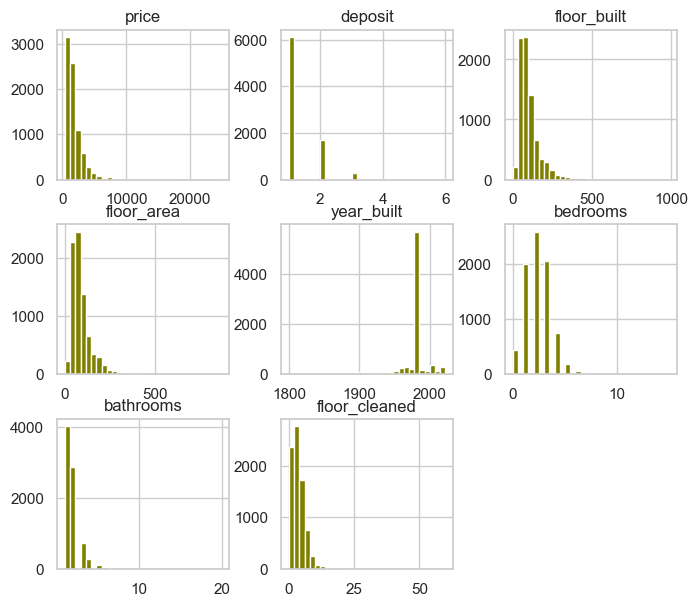

In [68]:
df.hist(figsize=(8, 7), bins=30, color='olive')
plt.show()

'floor_built' y 'floor_area' tienen un sesgo hacia la derecha, con valores extremos que parecen ser outliers
'price' presente también valores extremos pero no se puede determinar si son outliers.
El resto de las variables parecen tener una distribución normal.

#### Análisis detallado

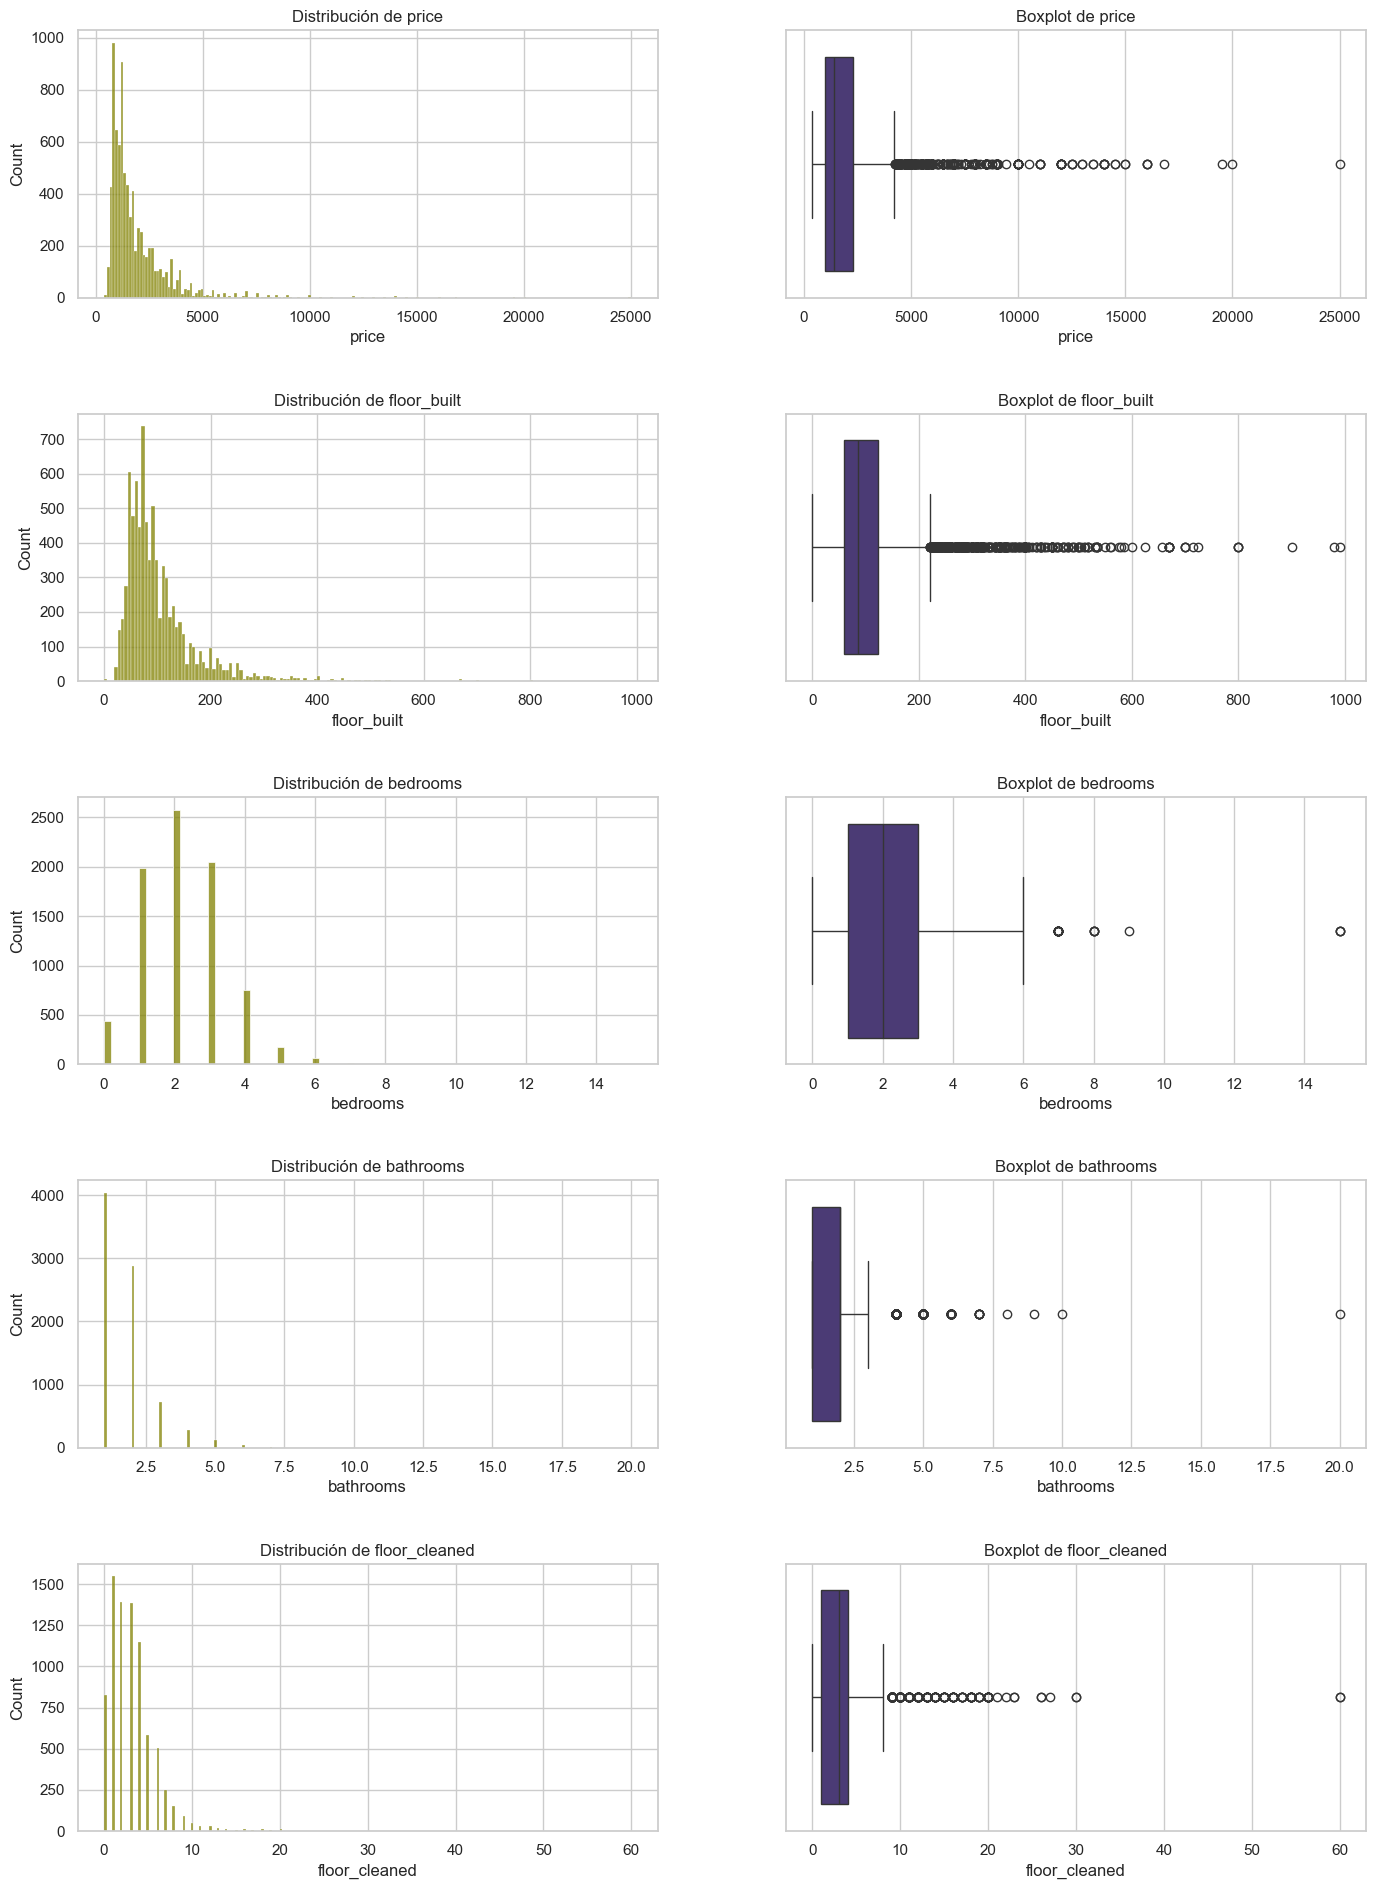

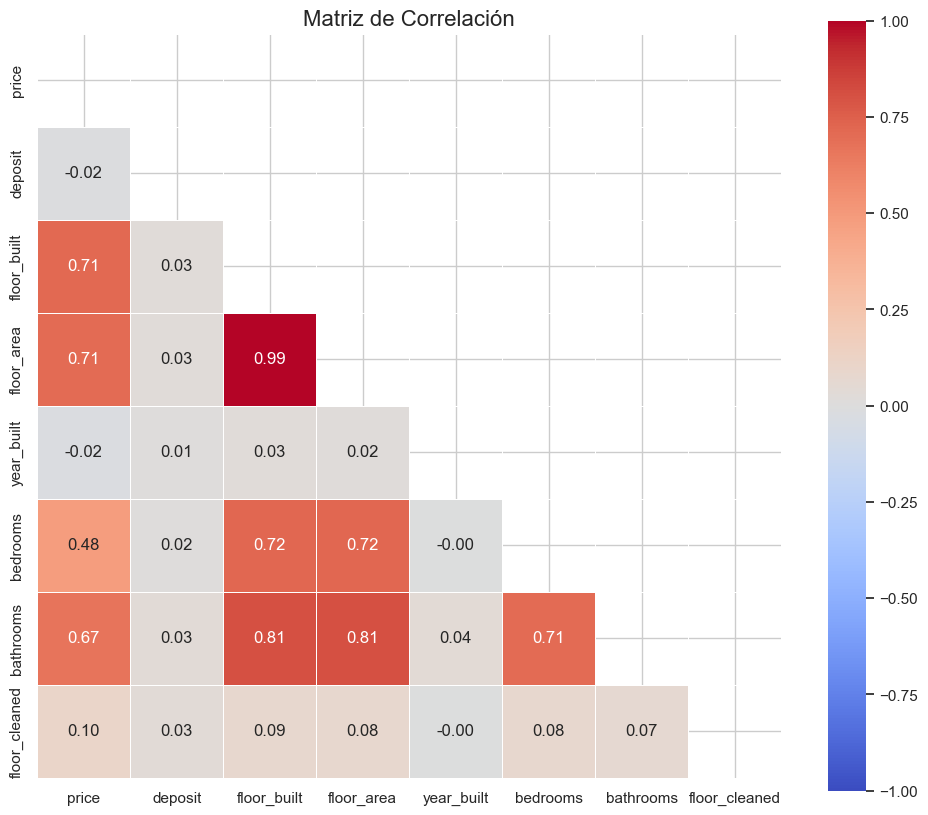

In [69]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid") 
sns.set_palette("viridis")

# Se seleccionan las variables numéricas relevantes
numeric_vars = ['price', 'floor_built', 'bedrooms', 'bathrooms', 'floor_cleaned']

fig, axes = plt.subplots(len(numeric_vars), 2, figsize=(15, 4*len(numeric_vars)))
fig.tight_layout(pad=5.0)

for i, var in enumerate(numeric_vars):
    # Histograma
    sns.histplot(df[var].dropna(), kde=False, ax=axes[i, 0], color='olive')
    axes[i, 0].set_title(f'Distribución de {var}')
    axes[i, 0].set_xlabel(var)
    
    # Boxplot
    sns.boxplot(x=df[var].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {var}')
    axes[i, 1].set_xlabel(var)

plt.show()

# Correlaciones entre variables numéricas
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

# Heatmap con ocultación del triángulo inferior
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()

ANÁLISIS DE VARIABLES CATEGÓRICAS

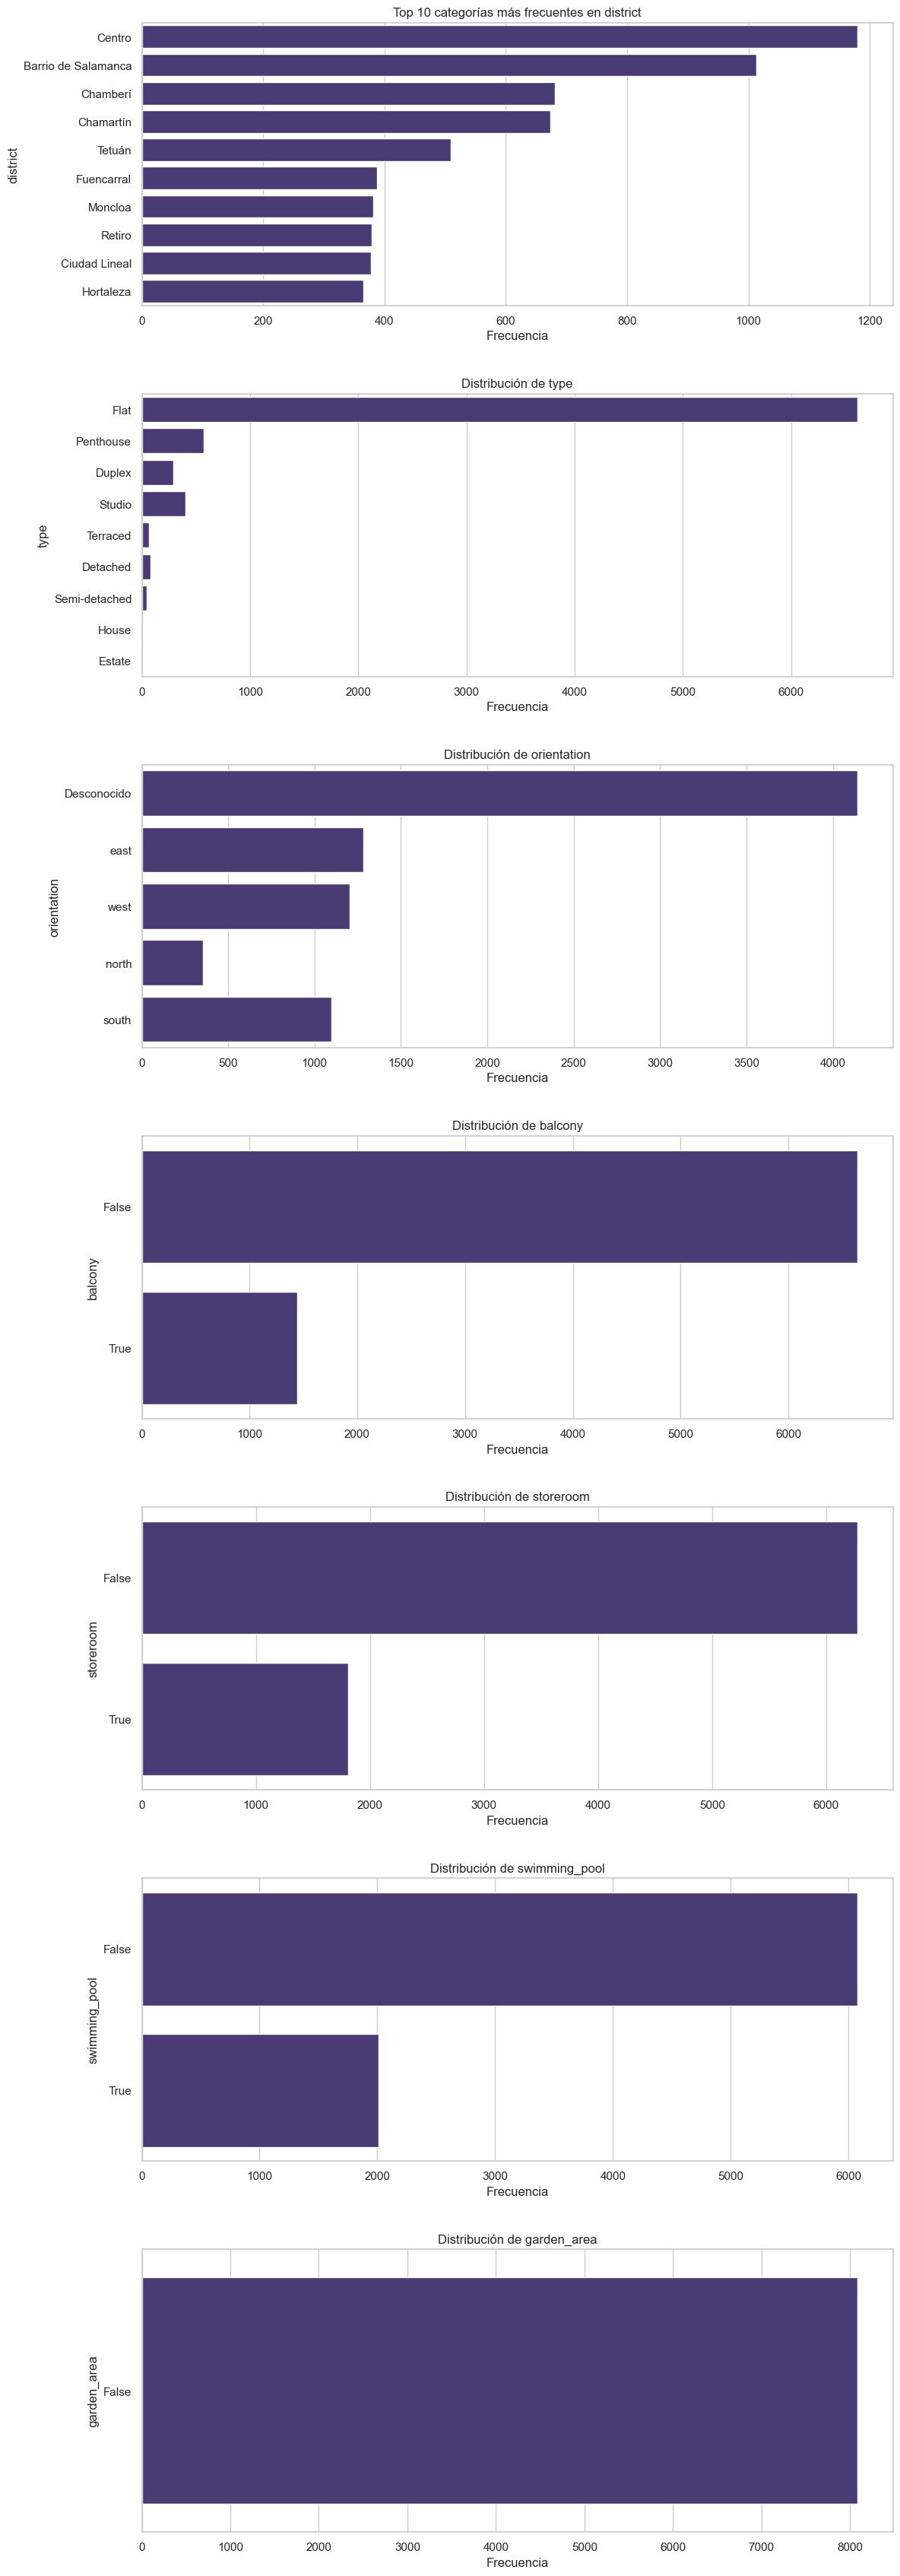

In [70]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid") 
sns.set_palette("viridis")

# variables categóricas relevantes
cat_vars = ['district', 'type', 'orientation', 'balcony', 'storeroom', 'swimming_pool', 'garden_area']

# Configurar subplots
fig, axes = plt.subplots(len(cat_vars), 1, figsize=(12, 5*len(cat_vars)))
fig.tight_layout(pad=5.0)

for i, var in enumerate(cat_vars):
    # Para variables con muchas categorías, limitamos a las 10 más frecuentes
    if df[var].nunique() > 10:
        # Contamos los 10 valores más frecuentes
        top_categories = df[var].value_counts().nlargest(10).index
        # Filtramos el dataframe
        temp_df = df[df[var].isin(top_categories)].copy()
        temp_df[var] = temp_df[var].astype(str)
        # Creamos el gráfico
        sns.countplot(y=var, data=temp_df, ax=axes[i], order=temp_df[var].value_counts().index)
        axes[i].set_title(f'Top 10 categorías más frecuentes en {var}')
    else:
        # Para variables con pocas categorías, mostramos todas
        sns.countplot(y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Distribución de {var}')
    
    axes[i].set_xlabel('Frecuencia')
    axes[i].set_ylabel(var)

plt.show()


RELACIÓN ENTRE PRECIO Y VARIABLES CATEGÓRICAS

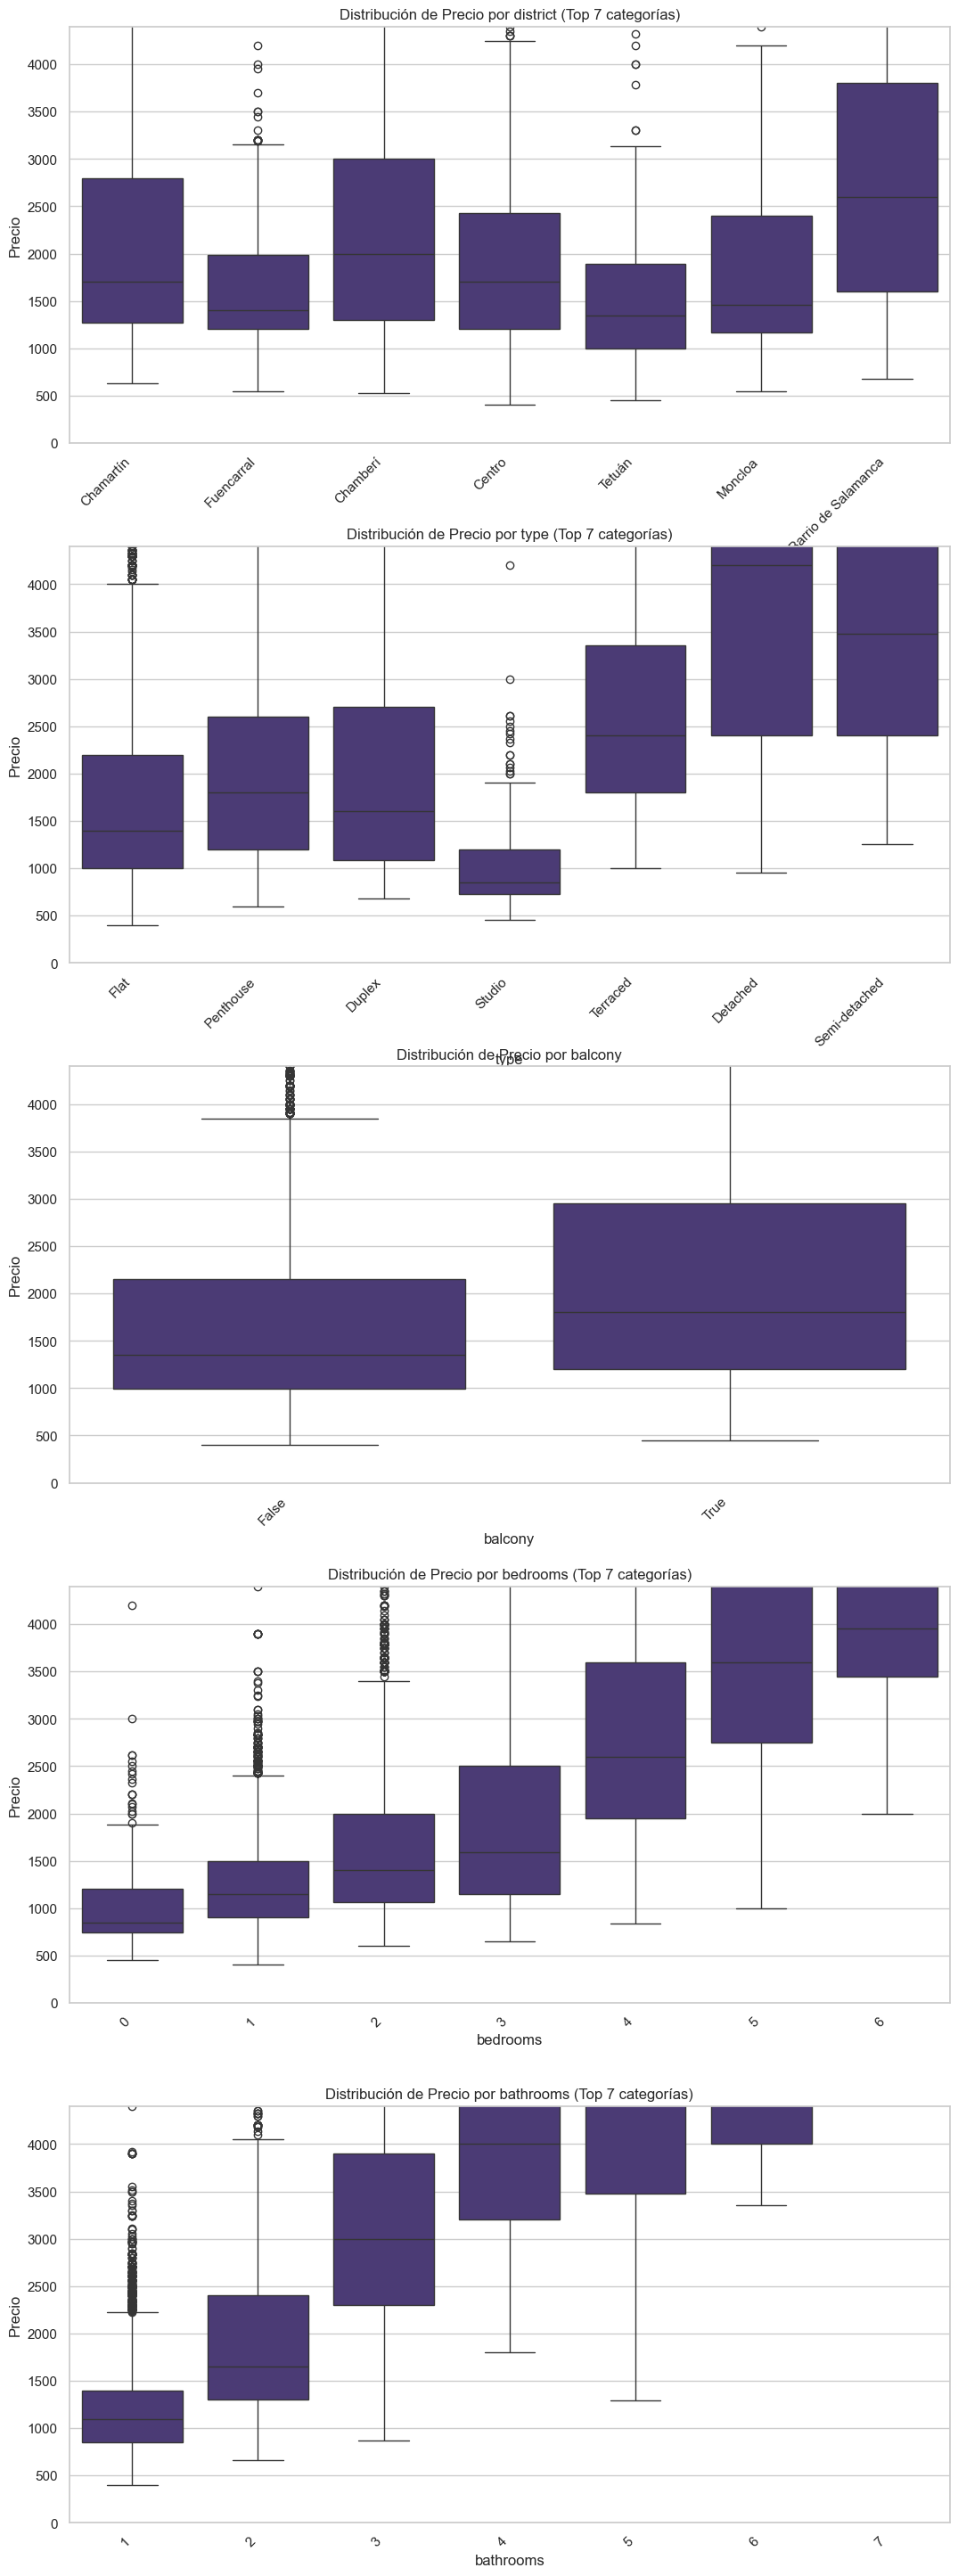

In [71]:

# Selección de variables categóricas a analizar vs precio
cat_price_vars = ['district', 'type', 'balcony', 'bedrooms', 'bathrooms']

fig, axes = plt.subplots(len(cat_price_vars), 1, figsize=(12, 6*len(cat_price_vars)))
fig.tight_layout(pad=5.0)

for i, var in enumerate(cat_price_vars):
    if df[var].nunique() > 7:
        # limitamos a las 7 más frecuentes
        top_categories = df[var].value_counts().nlargest(7).index
        temp_df = df[df[var].isin(top_categories)].copy()
        sns.boxplot(x=var, y='price', data=temp_df, ax=axes[i])
        axes[i].set_title(f'Distribución de Precio por {var} (Top 7 categorías)')
    else:
        sns.boxplot(x=var, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Distribución de Precio por {var}')
    
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Precio')

    # Visualizamos hasta el percentil 95
    axes[i].set_ylim(0, df['price'].quantile(0.95))
    # Rotar etiquetas si son largas
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.show()


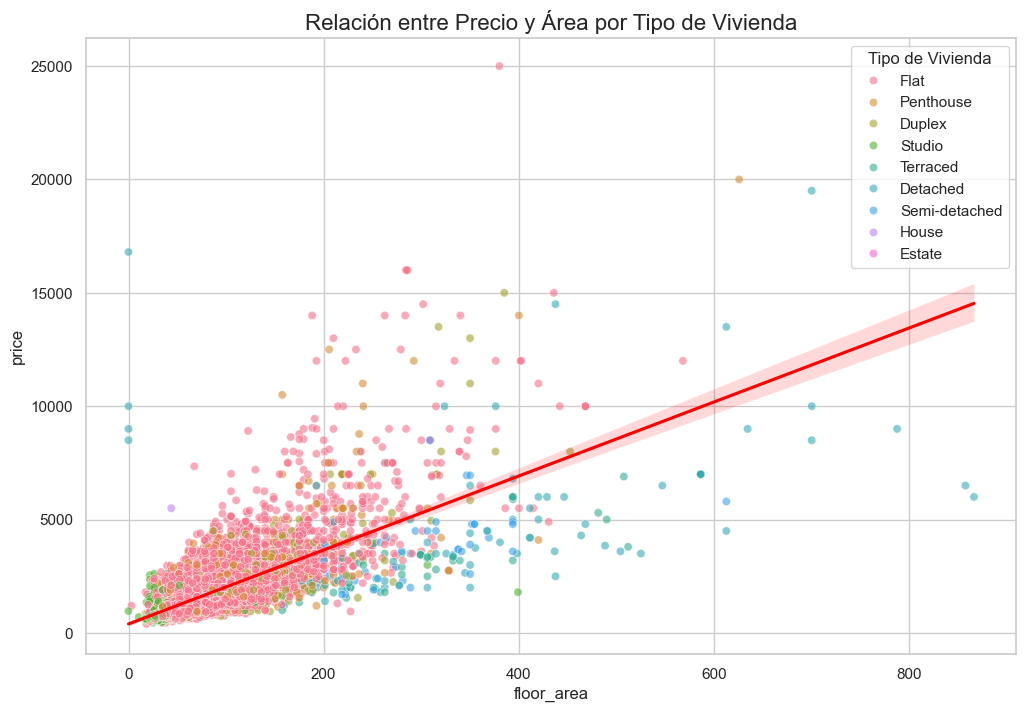

In [72]:
# Relación entre Precio y Área
plt.figure(figsize=(12, 8))
sns.scatterplot(x='floor_area', y='price', data=df, hue='type', alpha=0.6)
plt.title('Relación entre Precio y Área por Tipo de Vivienda', fontsize=16)
plt.xlabel('Área (m²)')
plt.ylabel('Precio (€)')

# Añadir línea de regresión
sns.regplot(x='floor_area', y='price', data=df, scatter=False, color='red')
plt.legend(title='Tipo de Vivienda')
plt.show()

- Vemos colinealidad entre floor_built y floor_area, lo que es de esperar.
- Vemos que 'price' tiene una correlación positiva con 'floor_built' y 'floor_area'. 
- La correlación entre 'bathrooms', 'bedrooms' y 'floor_built' es positiva, explica la correlación entre 'bathrooms' y 'bedrooms' con el precio. Tiene sentido porque cuánto más espacio útil tiene una vivienda, más habitaciones y baños tiene. 

#### Escalado

In [73]:
# StandardScaler

numeric_vars = ['price', 'floor_area', 'floor_built', 'bedrooms', 'bathrooms']
numeric_df = df[numeric_vars].copy()

scaler = StandardScaler()
numeric_df_scaled = pd.DataFrame(
    scaler.fit_transform(numeric_df),
    columns=numeric_df.columns
)

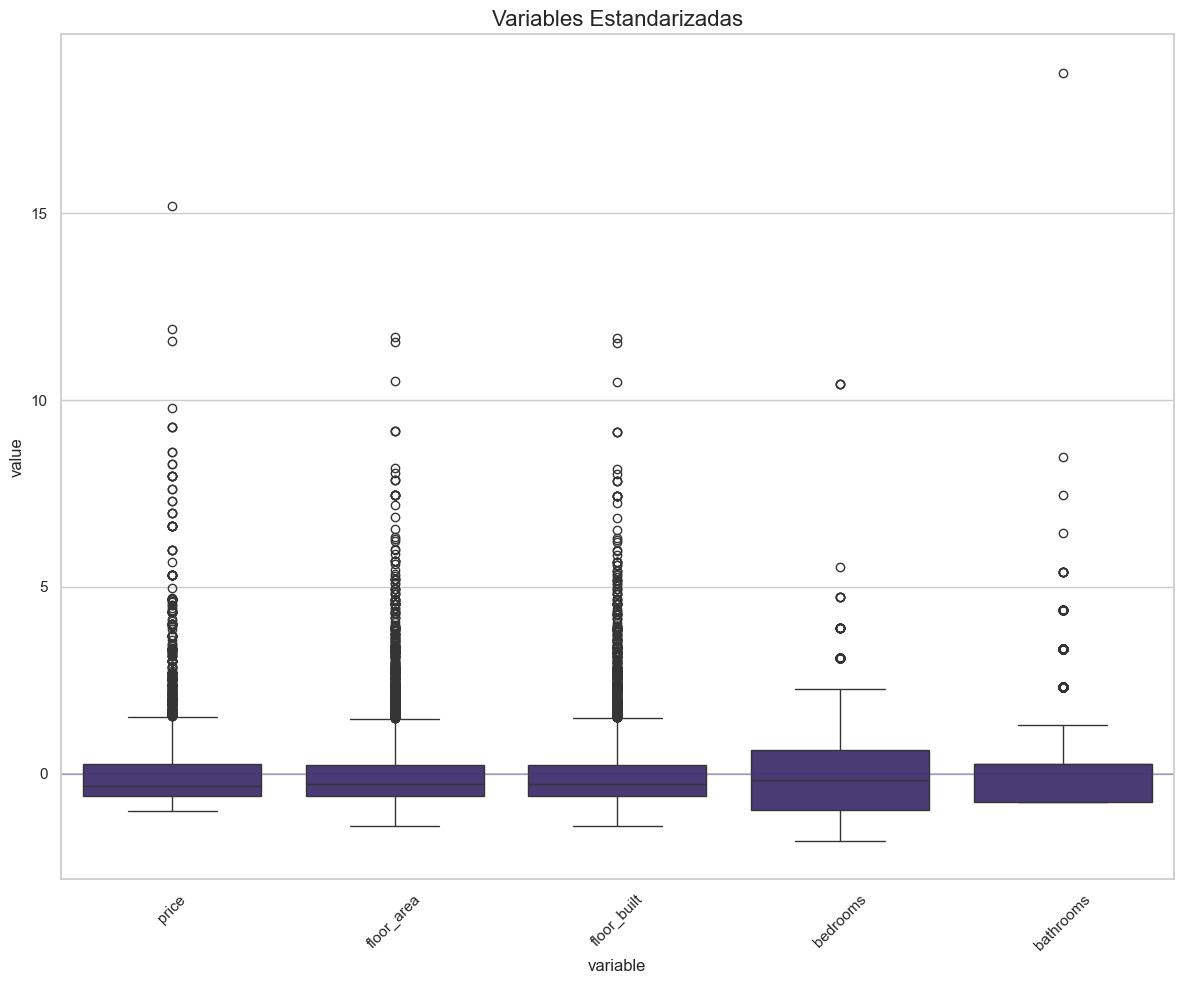

In [74]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=numeric_df_scaled.melt(), x='variable', y='value')
plt.title('Variables Estandarizadas', fontsize=16)
plt.xticks(rotation=45)
plt.axhline(y=0, alpha=0.3)
plt.tight_layout()
plt.show()

Con el escalado las variables pueden, al tener la mediana cerca de cero, compararse más fácilmente entre sí. Se observan mñas outliers en 'price' y 'floor_built' y 'floor_area' tras el escalado.

<Figure size 1500x1200 with 0 Axes>

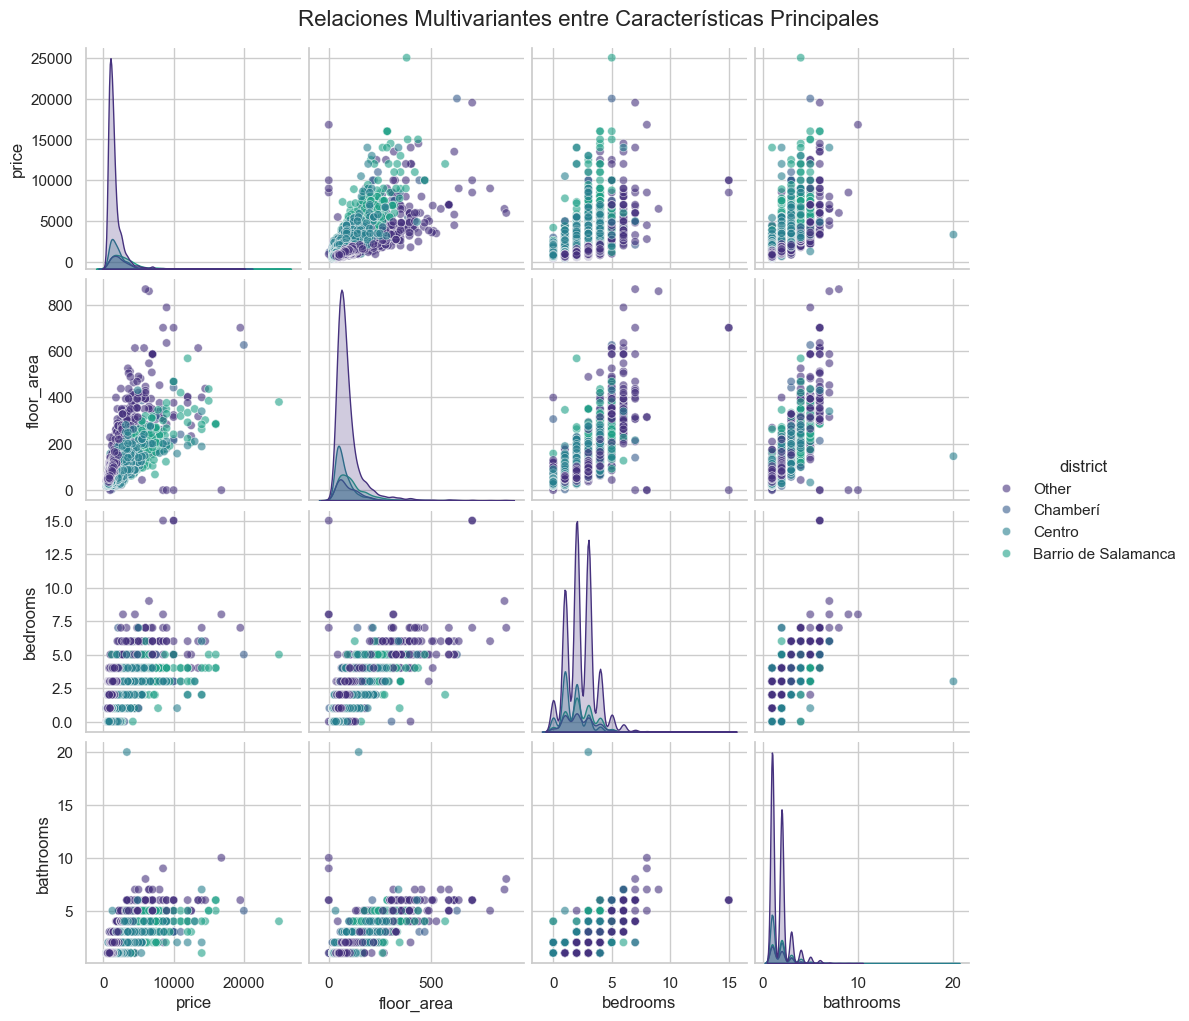

In [75]:
plot_df = df[['price', 'floor_area', 'bedrooms', 'bathrooms', 'district']].copy()
top_districts = df['district'].value_counts().nlargest(3).index
plot_df['district'] = plot_df['district'].apply(lambda x: x if x in top_districts else 'Other')

plt.figure(figsize=(15, 12))
sns.pairplot(plot_df, hue='district', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Relaciones Multivariantes entre Características Principales', fontsize=16, y=1.02)
plt.show()

## 3. Preprocesamiento

División Train train/test

In [76]:
# Definir las características y la variable objetivo
X = df.drop(columns=['price', 'professional_name'])
y = df['price']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir columnas categóricas y numéricas
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
print('numerical_columns', numerical_cols)

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
print('\ncategorical_columns',categorical_cols)

numerical_columns Index(['deposit', 'floor_built', 'floor_area', 'year_built', 'bedrooms',
       'bathrooms', 'floor_cleaned'],
      dtype='object')

categorical_columns Index(['type', 'private_owner', 'orientation', 'second_hand', 'lift',
       'garage_included', 'furnished', 'equipped_kitchen', 'fitted_wardrobes',
       'air_conditioning', 'terrace', 'balcony', 'storeroom', 'swimming_pool',
       'garden_area', 'district'],
      dtype='object')


Tratamiento de valores únicos

In [77]:
# Valores Únicos en Columnas Categóricas
print("\n========== Valores Únicos en Columnas Categóricas ==========")
for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"{col}: {n_unique} valores únicos")

# Analicemos "type" antes del fit
print("========== Conteo de 'type' ==========")
print(df['type'].value_counts())

# Eliminar filas con tipos raros
rare_types = ['House', 'Estate']  # Valores raros en 'type'
df = df[~df['type'].isin(rare_types)]

print("========== 'type' despues de eliminar ==========")
print(df['type'].value_counts()) # Se verifica


========== Valores Únicos en Columnas Categóricas ==========
type: 9 valores únicos
private_owner: 2 valores únicos
orientation: 5 valores únicos
second_hand: 2 valores únicos
lift: 2 valores únicos
garage_included: 2 valores únicos
furnished: 2 valores únicos
equipped_kitchen: 2 valores únicos
fitted_wardrobes: 2 valores únicos
air_conditioning: 2 valores únicos
terrace: 2 valores únicos
balcony: 2 valores únicos
storeroom: 2 valores únicos
swimming_pool: 2 valores únicos
garden_area: 1 valores únicos
district: 117 valores únicos
========== Conteo de 'type' ==========
type
Flat             6611
Penthouse         572
Studio            401
Duplex            295
Detached           83
Terraced           69
Semi-detached      46
House               2
Estate              1
Name: count, dtype: int64
========== 'type' despues de eliminar ==========
type
Flat             6611
Penthouse         572
Studio            401
Duplex            295
Detached           83
Terraced           69
Semi-det

In [78]:
# Se analiza 'district'
print("========== Conteo de 'district' ==========")
print(df['district'].value_counts())
district_counts = df['district'].value_counts()

========== Conteo de 'district' ==========
district
Centro                           1179
Barrio de Salamanca              1013
Chamberí                          681
Chamartín                         673
Tetuán                            509
                                 ... 
Fontenebro - Altavista              1
Urb. este - Montepríncipe           1
Pinosol - El Alcor - Peralejo       1
Parque Roma - Coronas               1
La Espinilla - Parque Blanco        1
Name: count, Length: 117, dtype: int64


Dado que hay muchos valores distintos en 'districts', vamos a hacer que el one hot encoder maneje categorías desconocidas con 'ignore'.
Con los valores únicos de 'type', como son solo 3, los eliminamos

#### Tratamiento de sesgos

In [79]:
# Función para transformación logarítmica segura
def log_transform(X):
    return np.log1p(X) 

def inverse_log_transform(X):
    return np.expm1(X)  # exp(x)-1 invierte log1p

# Función para eliminar outliers usando IQR
def remove_outliers(df, columns, factor=1.5):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Marcar outliers
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        print(f"Eliminando {outliers.sum()} outliers de {col}")
        
        # Filtrar outliers
        df_clean = df_clean[~((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound))]
    
    return df_clean


In [80]:

# Feature Engineering
def feature_engineering(df):
    df_new = df.copy()
    
    # Precio por metro cuadrado
    df_new['price/m2'] = df_new['price'] / df_new['floor_built']
    
    # Ratio habitaciones/baños
    df_new['room_bath_ratio'] = df_new['bedrooms'] / df_new['bathrooms'].replace(0, 1)

    return df_new


In [81]:
# Preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


## 4. Modelado

In [82]:
# pipeline numéricas
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
pipeline_numerical = make_pipeline(
    IterativeImputer(RandomForestRegressor(), random_state=42, initial_strategy='median'),
    StandardScaler()
)

# pipeline categóricas
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
pipeline_categorical = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)

# unir pipelines con ColumnTransformer
preprocessor = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols),
    ('categorical', pipeline_categorical, categorical_cols)
])

# pipeline final con el modelo
pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor()
)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42)

}

results = {}


In [83]:
for name, model in models.items():
    # pipeline final con cada modelo
    pipeline = make_pipeline(preprocessor, model)
    
    # Entrenar modelo
    pipeline.fit(X_train, y_train)
    
    # Predecir
    y_pred = pipeline.predict(X_test)
    
    # Evaluar
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Guardar resultados
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  MAE: {mae:.2f}")
    print("-" * 40)

RandomForest:
  RMSE: 690.36
  R2 Score: 0.7981
  MAE: 402.81
----------------------------------------
GradientBoosting:
  RMSE: 738.92
  R2 Score: 0.7687
  MAE: 451.05
----------------------------------------
KNN:
  RMSE: 818.42
  R2 Score: 0.7162
  MAE: 499.20
----------------------------------------
DecisionTree:
  RMSE: 960.22
  R2 Score: 0.6094
  MAE: 510.47
----------------------------------------


Random Forest obtiene el mejor rendimiento, así que lo optimizamos con GridSearchCV.


Comparación de modelos de regresión:
                            MSE        RMSE        R2         MAE
RandomForest      476590.628249  690.355436  0.798090  402.814065
GradientBoosting  546009.555908  738.924594  0.768681  451.052918
KNN               669816.380545  818.423106  0.716230  499.197772
DecisionTree      922029.279773  960.223557  0.609379  510.472033


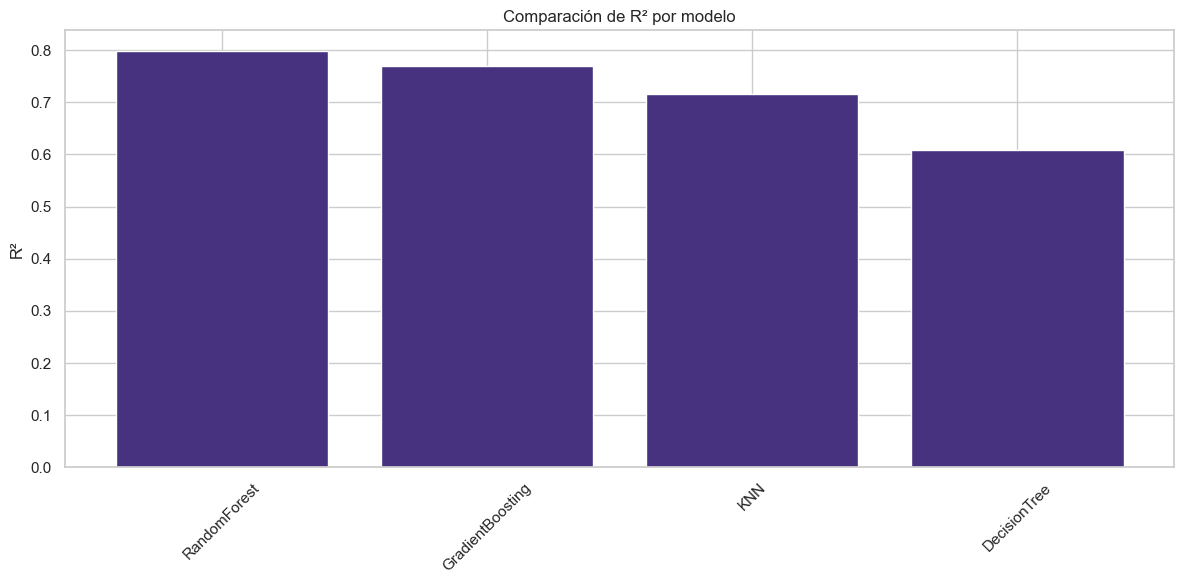

In [84]:
results_df = pd.DataFrame(results).T
print("\nComparación de modelos de regresión:")
print(results_df)

plt.figure(figsize=(12, 6))
plt.bar(results_df.index, results_df['R2'])
plt.title('Comparación de R² por modelo')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### CLASIFICACIÓN BINARIA PARA BALCONY

RandomForest (Clasificación):
  Accuracy: 0.8075
              precision    recall  f1-score   support

       False       0.82      0.97      0.89      1302
        True       0.52      0.14      0.22       314

    accuracy                           0.81      1616
   macro avg       0.67      0.55      0.55      1616
weighted avg       0.76      0.81      0.76      1616

----------------------------------------
DecisionTree (Clasificación):
  Accuracy: 0.8032
              precision    recall  f1-score   support

       False       0.82      0.96      0.89      1302
        True       0.48      0.15      0.23       314

    accuracy                           0.80      1616
   macro avg       0.65      0.56      0.56      1616
weighted avg       0.76      0.80      0.76      1616

----------------------------------------


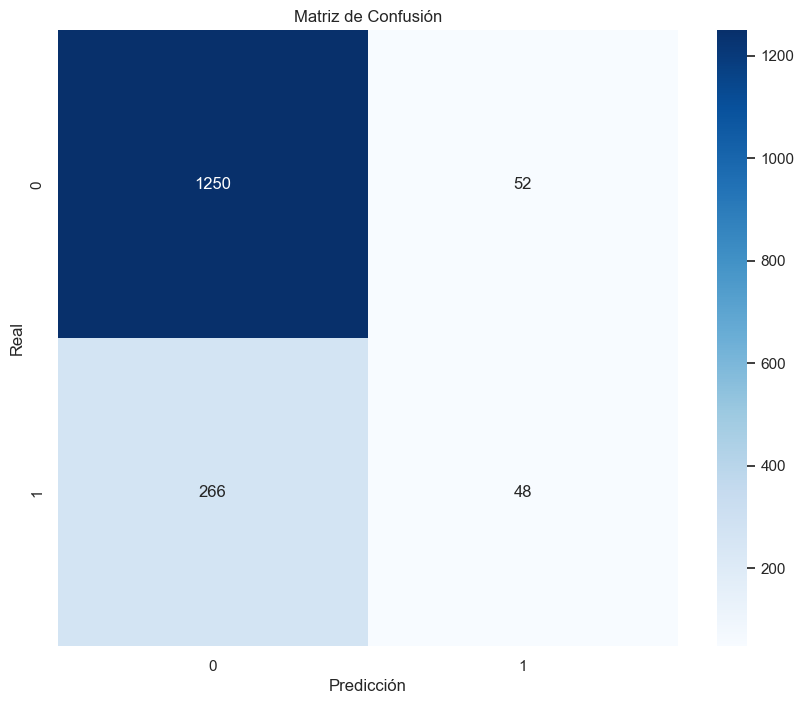

In [85]:
# Definimos X e y para clasificación
X_class = df.drop(columns=['balcony', 'price', 'professional_name'])
y_class = df['balcony']

# Dividimos en train y test
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Definimos columnas
numerical_cols_class = X_train_class.select_dtypes(include=[np.number]).columns
categorical_cols_class = X_train_class.select_dtypes(exclude=[np.number]).columns

# Preprocesamiento
class_preprocessor = ColumnTransformer([
    ('numeric', pipeline_numerical, numerical_cols_class),
    ('categorical', pipeline_categorical, categorical_cols_class)
])

# Modelos para clasificación
class_models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
}

# Resultados
class_results = {}

for name, model in class_models.items():
    class_pipeline = make_pipeline(class_preprocessor, model)
    
    # Entrenamiento
    class_pipeline.fit(X_train_class, y_train_class)
    
    # Predicción
    y_pred_class = class_pipeline.predict(X_test_class)
    
    # Evaluación
    accuracy = accuracy_score(y_test_class, y_pred_class)
    
    class_results[name] = {
        'Accuracy': accuracy,
    }
    
    print(f"{name} (Clasificación):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_class, y_pred_class))
    print("-" * 40)

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

El rendimiento es similar en ambos modelos, pero predicen mejor los que tienen balcón. Se explica porque hay más datos de viviendas con balcón que sin.

Respecto a la matriz de confusión, confirma la sospecha.